In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
import networkx as nx
from numpy import random

### Correlation dimension
Script to calculate the correlation dimension of a network in an embedding space of dimension d.

In [12]:
# Define variables s and d (size of the graph and dimension of the embedding)
s = 8  # Example value for graph size, modify as needed
d = 3   # Example value for embedding dimension, modify as needed

# Generate a Dorogovtsev-Goltsev-Mendes graph
G = nx.dorogovtsev_goltsev_mendes_graph(s)
N = len(G.nodes())  # Number of nodes in the graph

# Generate random data points in a d-dimensional space
x = random.uniform(0, 1, size=(N, d))

# Calculate the graph's adjacency matrix and degree of each node
adj = nx.adjacency_matrix(G)
diabs = np.array(adj.sum(axis=1)).flatten()

# Construct the graph Laplacian
slapl = diags(diabs, 0, format='csr', dtype=np.float64) - adj

# Compute the eigenvectors of the Laplacian
_, eigV = eigsh(slapl, k=d + 1, which='SM')

# Normalize the eigenvectors
eigV = np.array([vec / np.linalg.norm(vec) for vec in eigV.T])

# Set the coordinates of data points to the first d eigenvectors
x = eigV[1:d+1].T  # Use the first d eigenvectors for the coordinates

# Initialize a k-d tree for efficient spatial queries
tree = cKDTree(x)

# Calculate the nearest neighbor distances and indices (k=2 to find the nearest neighbor)
nearest_dist, nearest_ind = tree.query(x, k=2, workers=-1)

# Define the number of steps for scaling
nrsteps = 75
rsP = np.logspace(-15, 0, nrsteps)  # Logarithmic space for radial scales

# Preallocate arrays for the correlation dimensions
CdsP = np.zeros(nrsteps)

# Calculate the correlation dimensions for each scale
for cont, r1 in enumerate(rsP):
    points = 0  # Counter for the number of points within the distance r1

    # For each point, find all points within distance r1
    for i in range(len(x)):
        ix_list = tree.query_ball_point(x[i], r1, workers=-1)  # Points within distance r1
        points += len(ix_list) - 1  # Subtract 1 to exclude the point itself

    # Calculate the correlation dimension at this scale
    CdsP[cont] = points / len(x)  # Average number of points within distance r1

    # If the number of points reaches the maximum possible (N-1), stop
    if CdsP[cont] == N - 1:
        CdsP[cont:] = N - 1  # Set the remaining values to N-1
        break  # Exit the loop if the condition is met



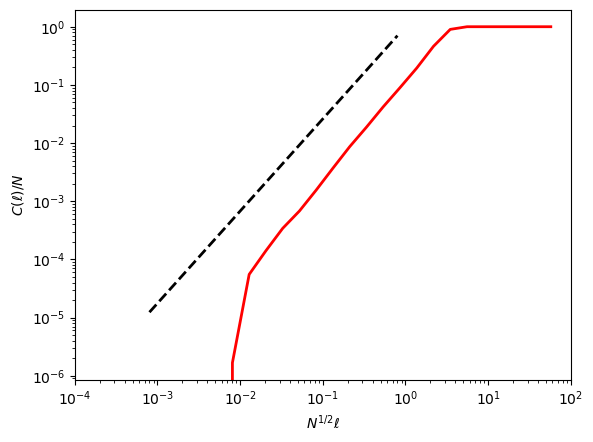

In [20]:
# Now you can plot or analyze CdsP
# Example plot
import matplotlib.pyplot as plt
plt.plot((N**0.5)*rsP, CdsP/N,lw=2,color='red')
x = np.linspace(8e-4,8e-1,200)
y = np.power(1*x**(3.17/2),1)
plt.plot(x,y,lw=2,ls='--',color='black')
plt.xscale('log')
plt.xlim(1e-4,1e2)
plt.yscale('log')
plt.ylabel(r'$C(\ell)/N$')
plt.xlabel(r'$N^{1/2}\ell$')
plt.show()

### Visualization
Visualization of data in a 3D embedding space

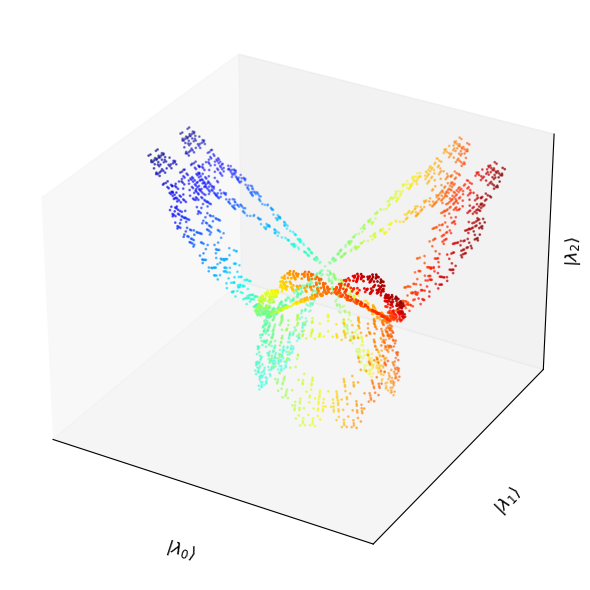

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and 3D axis
fig = plt.figure(figsize=(6, 6))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with better customization
scatter = ax.scatter(eigV[1], eigV[2], eigV[3], marker='o', s=1, c=eigV[1], cmap='jet')

# Labeling the axes with more descriptive labels
ax.set_xlabel(r'$|\lambda_0\rangle$', labelpad=10, fontsize=12)
ax.set_ylabel(r'$|\lambda_1\rangle$', labelpad=10, fontsize=12)
ax.set_zlabel(r'$|\lambda_2\rangle$', labelpad=-10, fontsize=12)

# Remove ticks from the axes for a cleaner look
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])
fig.tight_layout()
plt.show()
